In [25]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
from gym.utils import seeding
import networkx as nx

%matplotlib inline

In [26]:
class TSPGymEnv(gym.Env):

    def __init__(
        self, 
        G: nx.Graph,
        seed: int = None,
        **kwargs
    ):
        self.G = G
        self.seed = seed  # if not None, always reset to same state

        self.N = G.number_of_nodes()
        
        self.cur_node = None     # index of current node
        self.path_index = None   # index of current node in path
        
        self._initialize_node_data()
        self._initialize_edge_data()
        max_node_obs = max([self._get_node_obs(n) for n in G.nodes])
        
        self.observation_space = gym.spaces.Dict({
            "cur_node": gym.spaces.Discrete(self.N),
            "node_obs": gym.spaces.Discrete(max_node_obs),
            "next_nodes": gym.spaces.Box(0, self.N, shape=(self.N,), dtype=int)
        })
            
        self.action_space = gym.spaces.Discrete(self.N)
        
        
    def _initialize_node_data(self):
        for node, data in G.nodes.data():
            if "weight" not in data:
                G.nodes[node]["weight"] = G.degree[node]
            G.nodes[node]["visited"] = False
            G.nodes[node]["path_index"] = None
            
            
    def _initialize_edge_data(self):
        for ei, ej, data in G.edges.data():
            if "weight" not in data:
                G[ei][ej]["weight"] = 1.
            G[ei][ej]["path_index"] = None
        
    
    def _visit_node(self, node: int, index: int):
        self.G.nodes[node]["visited"] = True
        self.G.nodes[node]["path_index"] = index
        

    def _visit_edge(self, ei: int, ej: int, index: int):
        self.G[ei][ej]["visited"] = True
        self.G[ei][ej]["path_index"] = index


    def reset(self, seed: int = None):
        
        seeding.np.random.seed(seed if seed is not None else self.seed)
        
        self._initialize_node_data()
        self._initialize_edge_data()
        
        self.cur_node = seeding.np.random.choice(list(self.G.nodes))
        self.path_index = 0
        
        self._visit_node(self.cur_node, self.path_index)
        
        return self._get_obs()
        
    
    def _get_node_obs(self, node: int):
        return G.nodes[node]["weight"]
    
    
    def _get_unvisited_neighbors(self, node: int):
        nbrs = [n for n in G.neighbors(self.cur_node) if not G.nodes[n]["visited"]]
        nodes = np.zeros(self.N, dtype=int)
        nodes[nbrs] = 1
        return nodes
    
    
        
    def _get_obs(self):
        return {
            "cur_node": self.cur_node,
            "node_obs": self._get_node_obs(self.cur_node),
            "next_nodes": self._get_unvisited_neighbors(self.cur_node)
        }
    
        
    def step(self, action: np.ndarray):
        
        next_node = action[0]
        
        next_nodes = self._get_unvisited_neighbors(self.cur_node)
        assert next_nodes[next_node] == 1, \
            f"Edge ({node}, {self.cur_node}) is invalid"

        reward = -G[self.cur_node][next_node]["weight"]
        
        self._visit_edge(self.cur_node, next_node, self.path_index)

        self.cur_node = next_node
        self.path_index += 1
        self._visit_node(self.cur_node, self.path_index)
        
        obs = self._get_obs()
        done = obs["next_nodes"].max() == 0

        return obs, reward, done, {}


In [3]:
from scipy.spatial import distance_matrix

def make_complete_planar_graph(N, seed: int = None):
    """Returns a fully connected graph with xy positions for each
    node and edge weights equal to pairwise distances."""
    
    np.random.seed(seed)
    
    # Complete graph on points in xy-plane with pairwise distances as edge weights
    G = nx.complete_graph(N)

    pos = np.random.rand(N, 2)
    d = distance_matrix(pos, pos)
    
    for ei, ej in G.edges:
        G[ei][ej]["weight"] = d[ei][ej]
    
    for node in G.nodes:
        G.nodes[node]["pos"] = pos[node, :]
    
    return G

# Create and visualize simple network

In [18]:
N = 5
# G = nx.cycle_graph(N)
G = make_complete_planar_graph(N, seed=2)

In [19]:
def plot_network(G, path=None):
    
    fig, ax = plt.subplots()
    
    # Use pos attribute if it exists
    if "pos" not in G.nodes[0]:
        pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility
    else:
        pos = [G.nodes[n]["pos"] for n in G.nodes]
    
    _ = nx.draw_networkx_nodes(G, pos, node_size=200)
    _ = nx.draw_networkx_labels(G, pos, font_size=12, font_color="white")
    
    if path is None:
        _ = nx.draw_networkx_edges(G, pos, edgelist=list(G.edges), width=1)
    else:
        _ = nx.draw_networkx_edges(G, pos, edgelist=list(G.edges), width=.1)
        edgelist = [(path[i+1], path[i]) for i in range(len(path)-1)]
        _ = nx.draw_networkx_edges(G, pos, edgelist=edgelist, width=1)
        
    return fig, ax

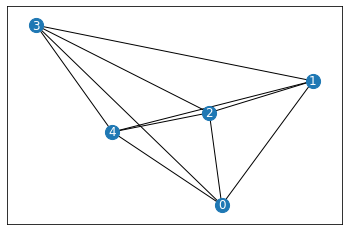

In [20]:
_ = plot_network(G, path=None)

# Solve TSP using nx heuristics

TSP solution [1, 4, 0, 2, 3]


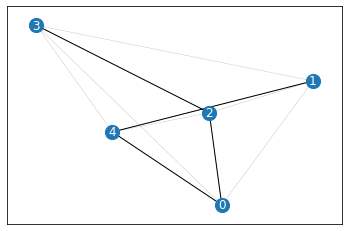

In [21]:
tsp = nx.approximation.traveling_salesman_problem
path = tsp(G, cycle=False)
print("TSP solution", path)

_ = plot_network(G, path=path)

# Demo of gym env with random actions

In [22]:
env = TSPGymEnv(G=G)
env.__dict__

{'G': <networkx.classes.graph.Graph at 0x15cff4c40>,
 'seed': None,
 'N': 5,
 'cur_node': None,
 'path_index': None,
 'observation_space': Dict(cur_node:Discrete(5), next_nodes:Box([0 0 0 0 0], [5 5 5 5 5], (5,), int64), node_obs:Discrete(4)),
 'action_space': Discrete(5)}

In [23]:
random.seed(42)
obs = env.reset(seed=42)
print(obs)

done = False
reward = 0.
path = [obs["cur_node"]]
while not done:
    nn = obs["next_nodes"]
    action = random.choice(np.where(nn)[0])
    path.append(action)
    obs, rew, done, _ = env.step([action])
    print(obs, rew, done)
    reward += rew
reward

{'cur_node': 3, 'node_obs': 4, 'next_nodes': array([1, 1, 1, 0, 1])}
{'cur_node': 0, 'node_obs': 4, 'next_nodes': array([0, 1, 1, 0, 1])} -0.6368509007229414 False
{'cur_node': 1, 'node_obs': 4, 'next_nodes': array([0, 0, 1, 0, 1])} -0.42488296534900866 False
{'cur_node': 4, 'node_obs': 4, 'next_nodes': array([0, 0, 1, 0, 0])} -0.30148715858147346 False
{'cur_node': 2, 'node_obs': 4, 'next_nodes': array([0, 0, 0, 0, 0])} -0.13639966186766653 True


-1.4996206865210902

Random path [3, 0, 1, 4, 2]


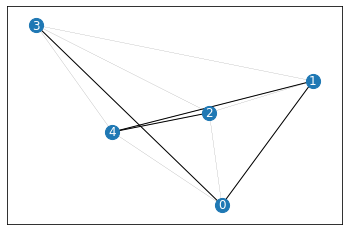

In [24]:
print("Random path", path)
_ = plot_network(G, path=path)